# Cosmology Calculator

### Noah Franz

Before doing anything else import everything we need

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import quad 
import matplotlib.pyplot as plt
import seaborn as sns

First we need to define some useful base classes to be used throughout

In [2]:
@dataclass
class Unit:
    '''
    A string representation of Units

    Also checks if stuff is in the correct unit
    '''

    # the string representation of the unit
    # There must be spaces between individual units
    # for example 'm s^-2' is valid but 'ms^-2' is not
    value: str  

    def __repr__(self):
        return self.value

    def __add__(self, other):
        return Unit(self.unit + other.unit)

    def __len__(self):
        return len(self.value)

In [92]:
class Value:
    '''
    A number with a unit. 
    
    Handles combining units so we can check things later!
    This is much less pretty than astropy units but should be
    good enough to help us convert later on!
    '''
    def __init__(self, value: float | int, unit: Unit=None):
        
        if unit is None:
            unit = Unit('') # assume it has no units
        
        if isinstance(unit, str):
            unit = Unit(unit)
        
        self.value = value
        self.unit = unit
    
    def __add__(self, other):
        if other.unit != self.unit:
            raise ValueError('Can not add values with different units!')
        
        return Value(self.value + other.value, self.unit)
    
    def __mul__(self, other):
        if len(other.unit) == 0:
            outunit = self.unit
        else:
            outunit = self.unit.value+' '+other.unit.value
        return Value(self.value * other.value, outunit)
    
    def __neg__(self):
        return Value(-self.value, self.unit)
    
    def __pow__(self, p:int):
        if len(self.unit) == 0:
            outunit = ''
        else:
            outunit = '('+self.unit.value+f')^{p}'
        return Value(self.value**p, outunit)
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        if len(other.unit) == 0:
            outunit = self.unit.value
        else:
            outunit = self.unit.value + ' (' + other.unit.value + ')^-1'
        return Value(self.value / other.value, outunit)
    
    def __repr__(self):
        return f'{self.value} {self.unit}'
    
    def __array__(self):
        # make it so numpy functions work
        return np.array(self.value)   
    
    def __getitem__(self, idx):
        return Value(self.value[idx], self.unit)

In [93]:
class Constants:
    c:Value = Value(3e8, 'm s^-1')

Now we can write the calculator

In [94]:
class CosmoCalc:
    
    def __init__(self, H0:Value, omega_m:Value, omega_lambda:Value, kappa:int=1):
        # This defines the "cosmology" we are working in
        
        if not isinstance(H0, Value):
            H0 = Value(H0, 'km s^-1 Mpc^-1') # assume units...
        
        if not isinstance(omega_m, Value):
            omega_m = Value(omega_m)
            
        if not isinstance(omega_lambda, Value):
            omega_lambda = Value(omega_lambda)
        
        self.H0 = H0
        self.omega_m = omega_m
        self.omega_lambda = omega_lambda
        self.k = Value(kappa) # The curvature measure
        
        # compute some other important values from the inputs
        self.omega_k = Value(1) - self.omega_m - self.omega_lambda 
        self.omega_0 = Value(1 + self.k.value * Constants.c.value**2 / self.H0.value**2)
        
        try:
            self.R_c = (self.k * Constants.c**2 / (self.H0**2 * self.omega_k))**(1/2)
        except ZeroDivisionError:
            self.R_c = Value(np.inf)
        
        # check some values
        print(f'H0 = {H0}')
        print(f'k = {self.k}')
        print(f'omega_k = {self.omega_k}')
        print(f'omega_0 = {self.omega_0}')
        print(f'R_c = {self.R_c}')
        
    def __repr__(self):
        return f'CosmoCalc(\n  H0={self.H0}\n  $\Omega_m$={self.omega_m}\n  $\Omega_\Lambda$={self.omega_lambda}\n)'
        
    def H(self, z):
        '''
        Hubble constant as a function of z
        '''
        val1 = self.omega_0.value*(1+z)**3 # this is unitless so it's safe to take the value
        val2 = (1-self.omega_0.value)*(1+z)**2 # this is unitless so it's safe to take the value
        return self.H0 * Value((val1 - val2)**(1/2))
        
    def comoving_distance(self, maxz, minz=0, **kwargs):
        '''
        compute the comoving distance
        '''
        
        integrand = lambda z: Constants.c / self.H(z)
        
        if not isinstance(maxz, np.ndarray):
            if isinstance(maxz, list):
                maxz = np.array(maxz)
            else:
                maxz = np.array([maxz])
        
        results = []
        for zz in maxz:
            zarr = np.linspace(minz, zz, **kwargs)
            I = integrand(zarr)
            res = np.trapz(I.value, zarr)
            results.append(res)
        
        return Value(np.array(results), I.unit)
        
    def luminosity_distance(self, z):
        '''
        compute the luminosity distance
        '''
        r = self.comoving_distance(z)
        return self.angular_diameter_distance(z) * Value((1+z)**2)
        
    def angular_diameter_distance(self, z):
        '''
        Compute the angular diameter distance
        '''
        r = self.comoving_distance(z)
        if np.isfinite(self.R_c):
            sin = Value(np.sin(r/self.R_c), (r/self.R_c).unit)
            return self.R_c * sin / Value(1 + z)
        else:
            return r / Value(1+z)
        
    def comoving_volume(self, z, **kwargs):
        '''
        Find the comoving volume
        '''
        r = self.comoving_distance(z, **kwargs)
        if np.isfinite(self.R_c):
            # not flat cosmology
            sin = Value(np.sin(r/self.R_c), (r/self.R_c).unit)
            return self.R_c**2 * sin**2 * Constants.c / self.H(z)
        else:
            # flat cosmology, we need to modify the formulas slightly
            return Constants.c * r**2 / (self.H0 * Value((1+z)**(3/2)))
    
    def distance_modulus(self, z):
        '''
        Compute the distance modulus
        '''
        dL = self.luminosity_distance(z)
        
        # need to convert to pc
        # I don't feel like writing a unit converter so I'm gonna hardcode this
        # NOTE: THIS COULD CAUSE PROBLEMS LATER, BE CAUTIOUS
        # Assuming dL is in the following nightmare unit
        #  m s^-1 (km s^-1 Mpc^-1)^-1
        dL_pc = (dL.value*1e-3)*1e6
        
        return 5*np.log10(dL_pc/10)
    
    def look_back_time(self, z):
        '''
        Calculate the look-back time
        '''
        integrand = lambda z: Value(1) / (self.H(z) * Value(1+z))
        
        results = []
        for zz in z:
            zarr = np.linspace(0, zz)
            I = integrand(zarr)
            res = np.trapz(I.value, zarr)
            results.append(res)
        
        return Value(np.array(results), I.unit)
    
    def luminosity(self, z, flux):
        '''
        Calculate the luminosity for this cosmology
        '''
        d = self.luminosity_distance(z)
        return Value(4*np.pi)*d**2*flux / Value(1+z)

# Problem 1
Produce plots of r(z), the angular diameter distance, the distance modulus
[5 log10(dL/10 pc)], the comoving volume per square degree per unit redshift, and the age of the
universe t(z), all as a function of redshift (say, between 0.1 and 5). Do this for three cosmologies:
Ωm, ΩΛ) = (1, 0), (0.3, 0), and (0.3, 0.7). Assuming H0 = 70 for problems 1, 2 and 3.
Interpret your findings, e.g. what are the trends between the cosmologies.

In [95]:
# construct calculators with our cosmologies
oms = [1, 0.3, 0.3]
ols = [0, 0, 0.7]
calculators = [CosmoCalc(70, om, ol) for om, ol in zip(oms, ols)]

# create an array of redshifts to use
# the calculator should be vectorized so using numpy we can just 
# pass this in to all the relevant methods to get numpy arrays out
z = np.linspace(0.1, 5, 100)

H0 = 70 km s^-1 Mpc^-1
k = 1 
omega_k = 0 
omega_0 = 18367346938776.51 
R_c = inf 
H0 = 70 km s^-1 Mpc^-1
k = 1 
omega_k = 0.7 
omega_0 = 18367346938776.51 
R_c = 5122408.32571883 ( (m s^-1)^2 ((km s^-1 Mpc^-1)^2)^-1)^0.5
H0 = 70 km s^-1 Mpc^-1
k = 1 
omega_k = 0.0 
omega_0 = 18367346938776.51 
R_c = inf 


Text(0, 0.5, 't(z) [ (km s^-1 Mpc^-1)^-1]')

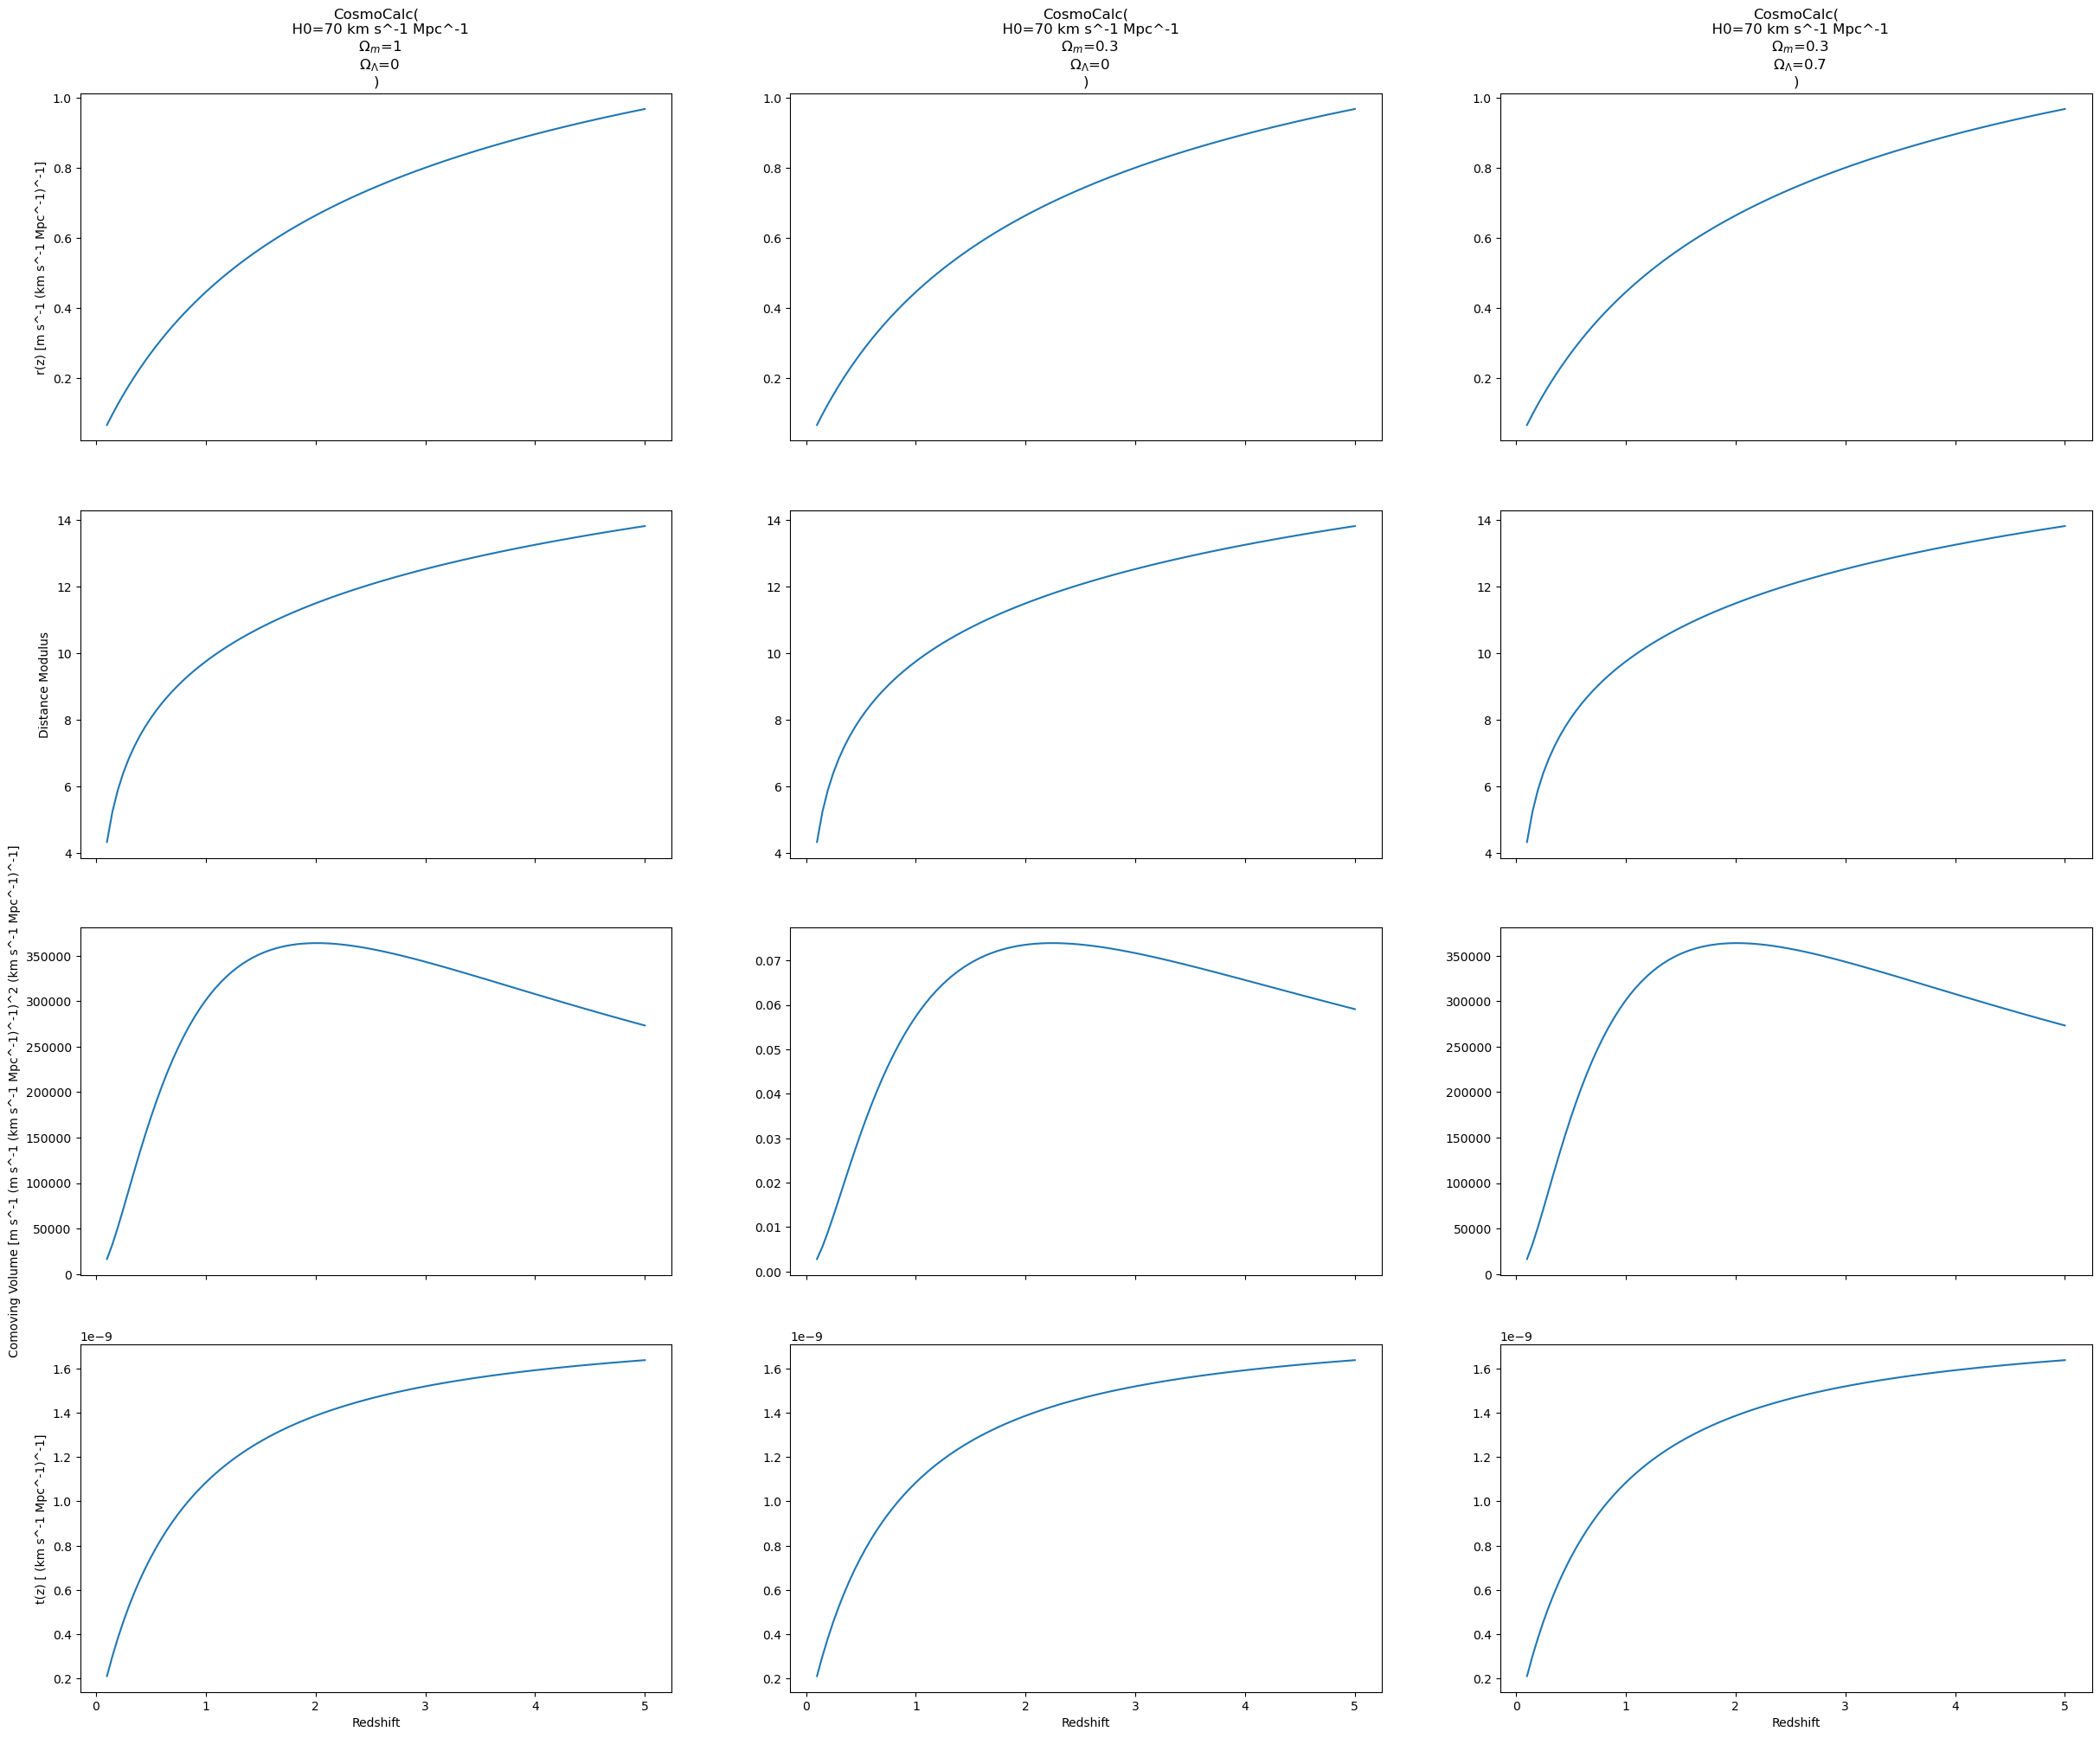

In [96]:
fig, ax = plt.subplots(4, 3, figsize=(30, 24), sharey=False, sharex=True)

for ii, cc in enumerate(calculators):
    ax[0,ii].set_title(cc)
    ax[-1,ii].set_xlabel('Redshift') # set the x label once for each column
    
    # first r(z)
    r = cc.comoving_distance(z)
    ax[0,ii].plot(z, r, '-')
    
    # then distance modulus
    D = cc.distance_modulus(z)
    ax[1,ii].plot(z, D)
    
    # then comoving volume
    V = cc.comoving_volume(z)
    ax[2,ii].plot(z, V)
    
    # then t(z)
    f = cc.look_back_time(z)
    ax[3, ii].plot(z, f)

# label the plots
ax[0,0].set_ylabel(f'r(z) [{r.unit}]')
ax[1,0].set_ylabel(f'Distance Modulus')
ax[2,0].set_ylabel(f'Comoving Volume [{V.unit}]')
ax[3,0].set_ylabel(f't(z) [{f.unit}]')

# Problem 2

magine that we have a galaxy at z ≈ 0 that is 10th magnitude in R at a
distance of 7 Mpc. If the identical galaxy were at z = 1.75, what would K magnitude be in each
of the three cosmologies in Problem 1?

At z = 1.75, the light that was emitted in the R band has been shifted to the K band. Imagine
that the two bands have the same fractional width, i.e. that the filter response as a function of
frequency in the two bands is simply rescaled, fK (ν) = fR(2.75ν). That means that the flux in the
emitted R band can be easily related to that in the observed K band without knowledge of the
spectrum of the object.

The flux per unit frequency of a 0th magnitude star are roughly Fν = 3080 Janskies for the R
band and Fν = 640 Janskies for the K band. 1 Jansky is 10−23 erg cm−2 s−1 Hz−1. Please note
that this is flux per unit frequency; it is not the total flux received through the bandpass. Irrelevant
note in case you’re interested in the fine technical details of photometric definitions: this is the amplitude of a spectrum with a constant flux per unit frequency that would give the same response
in the detector as the calibrating m = 0 star.

t is almost a truism in cosmology that there is always one more factor of 1 + z that one has
forgotten. You’ll need to think carefully about what the quantities in this problem mean to be sure
that your answer isn’t off by a factor of 2.75!

General note: in this case, by construction, we could map the light in emitted in one band to
that received in another band. In most cases, we’re not this lucky: the two bands don’t overlap. In
this case, one has to correct the flux based on the details of the spectrum of source and the filter
responses of the band passes. This is known as a K correction. These apply even if the emitted
band and the observed band are the same: because the photons are redshifted, the two bands are
not probing the identical part of the object’s spectrum! A pedagogical explanation of K corrections
is given by Hogg et al. (astro-ph/0210394).

In [97]:
def mag_to_flux(mag, ref):
    p = -mag/Value(2.5)
    exp = Value(10**(p.value))
    return ref * exp

In [98]:
# first, close by, object
z1 = 0
D1 = Value(7, 'Mpc')
m1 = Value(10) # apparent magnitude


# second, farther object
z2 = 1.75

# some other given information
Fv_R_ref = Value(3080, 'Jy')
Fv_K_ref = Value(640, 'Jy')

# compute the flux in each band from the given magnitude
F1_R = mag_to_flux(m1, Fv_R_ref)
F1_K = mag_to_flux(m1, Fv_K_ref)
Frat = F1_R.value/F1_K.value

# do the calculation
for cc in calculators:
    L_close = cc.luminosity(z1, F1_R)
    print(L_close)

[0.]  (m s^-1 (km s^-1 Mpc^-1)^-1)^2 Jy
[0.]  (( (m s^-1)^2 ((km s^-1 Mpc^-1)^2)^-1)^0.5 m s^-1 (km s^-1 Mpc^-1)^-1 (( (m s^-1)^2 ((km s^-1 Mpc^-1)^2)^-1)^0.5)^-1)^2 Jy
[0.]  (m s^-1 (km s^-1 Mpc^-1)^-1)^2 Jy


# Problem 3

If the number density of such galaxies is 0.01 Mpc−3 in the local universe
and if the galaxies are not changing, how many of these galaxies would be predicted in a 1 square
degree survey between z = 1.7 and z = 1.8? Compute this for all three cosmologies in Problem 1.
You need not do the integral between z = 1.7 and z = 1.8 more accurately than the width in
redshift times the value of the integrand at the central value.

In [102]:
n = Value(0.01, 'Mpc^-3')
omega = Value(1, 'deg^2')

for cc in calculators:
    V_dz_dOmega = cc.comoving_volume(z=1.8, minz=1.7)[0]
    V_dz = V_dz_dOmega * omega # omega is constant
    
    # integrate over the redshifts
    print(V_dz)

322.65601583644883 m s^-1 (m s^-1 (km s^-1 Mpc^-1)^-1)^2 (km s^-1 Mpc^-1)^-1 deg^2
6.462547816739693e-05 (( (m s^-1)^2 ((km s^-1 Mpc^-1)^2)^-1)^0.5)^2 (m s^-1 (km s^-1 Mpc^-1)^-1 (( (m s^-1)^2 ((km s^-1 Mpc^-1)^2)^-1)^0.5)^-1)^2 m s^-1 (km s^-1 Mpc^-1)^-1 deg^2
322.65601583644883 m s^-1 (m s^-1 (km s^-1 Mpc^-1)^-1)^2 (km s^-1 Mpc^-1)^-1 deg^2


# Problem 4

Consider two galaxies at z ≈ 1.75 that are separated by 40′′ on the sky and
∆z = 0.003 in redshift. Assuming that the redshift difference is strictly cosmological (probably not
a good assumption as we’ll learn later), what is the proper (not comoving) separation between the
galaxies. Again, do this for all three cosmologies in Problem 1.

# Problem 5

The age of a universe with Ωm = 1 and zero Λ is 2/3H0. We believe that
the universe is at least 12 Gyr old. What does this imply about H0 if the universe has Ωm = 1?
What are the limits on H0 if Ωm = 0.2 for: (a) an open model with Λ = 0; and (b) a flat model
with Λ = 1 − Ωm = 0.8.